In [21]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import wave

TensorFlow version: 2.6.0


In [22]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd

In [23]:
#importing  libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os


import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
#from include import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
#split the dataset into train and test
X_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_train_mfcc.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_train_mfcc.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_test_mfcc.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_test_mfcc.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4499, 40), (4499, 1), (4233, 41), (4233, 2))

In [25]:
#One hot encode labels

le = LabelEncoder()

def encoding_y(data):
  data = np.array(data['label'])
  data = to_categorical(le.fit_transform(data))
  return data

y_train = encoding_y(y_train)
y_test = encoding_y(y_test) 

In [26]:
X_test = X_test.iloc[:,1:41]
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets
def standardization(data):
  mean = np.mean(data,axis=0)
  std = np.std(data, axis=0)
  data =( data - mean)/std
  data = np.array(data)
  return data

X_train = standardization(X_train)
X_test = standardization(X_test)


In [27]:
model = Sequential()
model.add(layers.Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(750, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              41000     
_________________________________________________________________
dense_8 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [28]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              41000     
_________________________________________________________________
dense_8 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4499, 40), (4233, 40), (4499, 10), (4233, 10))

In [30]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 250
num_batch_size = 256
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model_mfc=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
18/18 [==============================] - 5s 156ms/step - loss: 1.6859 - accuracy: 0.4277 - val_loss: 1.7583 - val_accuracy: 0.4212

Epoch 00001: val_loss improved from inf to 1.75828, saving model to .\audio_classification.hdf5
Epoch 2/250
18/18 [==============================] - 2s 99ms/step - loss: 0.8804 - accuracy: 0.7144 - val_loss: 1.7636 - val_accuracy: 0.4883

Epoch 00002: val_loss did not improve from 1.75828
Epoch 3/250
18/18 [==============================] - 2s 98ms/step - loss: 0.5563 - accuracy: 0.8242 - val_loss: 1.9925 - val_accuracy: 0.4975

Epoch 00003: val_loss did not improve from 1.75828
Epoch 4/250
18/18 [==============================] - 1s 84ms/step - loss: 0.3514 - accuracy: 0.8842 - val_loss: 2.3396 - val_accuracy: 0.4857

Epoch 00004: val_loss did not improve from 1.75828
Epoch 5/250
18/18 [==============================] - 1s 82ms/step - loss: 0.2323 - accuracy: 0.9251 - val_loss: 2.6127 - val_accuracy: 0.4713

Epoch 00005: val_loss did not impro

18/18 [==============================] - 2s 99ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 5.0203 - val_accuracy: 0.5027

Epoch 00043: val_loss did not improve from 1.75828
Epoch 44/250
18/18 [==============================] - 2s 92ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 5.0237 - val_accuracy: 0.5046

Epoch 00044: val_loss did not improve from 1.75828
Epoch 45/250
18/18 [==============================] - 1s 76ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 5.0841 - val_accuracy: 0.5037

Epoch 00045: val_loss did not improve from 1.75828
Epoch 46/250
18/18 [==============================] - 2s 100ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 5.0455 - val_accuracy: 0.5044

Epoch 00046: val_loss did not improve from 1.75828
Epoch 47/250
18/18 [==============================] - 2s 95ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 5.1175 - val_accuracy: 0.5048

Epoch 00047: val_loss did not improve from 1.75828
Epoch 48/250
18/18 [=================

18/18 [==============================] - 1s 76ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 4.4510 - val_accuracy: 0.4994

Epoch 00085: val_loss did not improve from 1.75828
Epoch 86/250
18/18 [==============================] - 2s 92ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 4.2356 - val_accuracy: 0.5072

Epoch 00086: val_loss did not improve from 1.75828
Epoch 87/250
18/18 [==============================] - 2s 95ms/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 4.2161 - val_accuracy: 0.5093

Epoch 00087: val_loss did not improve from 1.75828
Epoch 88/250
18/18 [==============================] - 2s 103ms/step - loss: 0.0284 - accuracy: 0.9924 - val_loss: 4.2878 - val_accuracy: 0.4760

Epoch 00088: val_loss did not improve from 1.75828
Epoch 89/250
18/18 [==============================] - 2s 90ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 4.0205 - val_accuracy: 0.4867

Epoch 00089: val_loss did not improve from 1.75828
Epoch 90/250
18/18 [=================

18/18 [==============================] - 2s 89ms/step - loss: 8.2767e-04 - accuracy: 0.9991 - val_loss: 5.1114 - val_accuracy: 0.5098

Epoch 00126: val_loss did not improve from 1.75828
Epoch 127/250
18/18 [==============================] - 2s 95ms/step - loss: 7.6095e-04 - accuracy: 0.9996 - val_loss: 5.1500 - val_accuracy: 0.5089

Epoch 00127: val_loss did not improve from 1.75828
Epoch 128/250
18/18 [==============================] - 2s 103ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 5.1313 - val_accuracy: 0.5110

Epoch 00128: val_loss did not improve from 1.75828
Epoch 129/250
18/18 [==============================] - 2s 101ms/step - loss: 9.1130e-04 - accuracy: 0.9996 - val_loss: 5.1692 - val_accuracy: 0.5079

Epoch 00129: val_loss did not improve from 1.75828
Epoch 130/250
18/18 [==============================] - 2s 93ms/step - loss: 8.0051e-04 - accuracy: 0.9996 - val_loss: 5.1529 - val_accuracy: 0.5107

Epoch 00130: val_loss did not improve from 1.75828
Epoch 131/250
18

18/18 [==============================] - 2s 110ms/step - loss: 9.1385e-04 - accuracy: 0.9996 - val_loss: 5.4081 - val_accuracy: 0.5136

Epoch 00167: val_loss did not improve from 1.75828
Epoch 168/250
18/18 [==============================] - 2s 111ms/step - loss: 7.1204e-04 - accuracy: 0.9996 - val_loss: 5.4367 - val_accuracy: 0.5119

Epoch 00168: val_loss did not improve from 1.75828
Epoch 169/250
18/18 [==============================] - 2s 127ms/step - loss: 7.3813e-04 - accuracy: 0.9996 - val_loss: 5.4561 - val_accuracy: 0.5117

Epoch 00169: val_loss did not improve from 1.75828
Epoch 170/250
18/18 [==============================] - 2s 102ms/step - loss: 6.6139e-04 - accuracy: 0.9996 - val_loss: 5.4900 - val_accuracy: 0.5100

Epoch 00170: val_loss did not improve from 1.75828
Epoch 171/250
18/18 [==============================] - 1s 82ms/step - loss: 6.8647e-04 - accuracy: 0.9996 - val_loss: 5.5095 - val_accuracy: 0.5112

Epoch 00171: val_loss did not improve from 1.75828
Epoch 172/

18/18 [==============================] - 2s 86ms/step - loss: 7.3406e-04 - accuracy: 0.9996 - val_loss: 5.8478 - val_accuracy: 0.5148

Epoch 00208: val_loss did not improve from 1.75828
Epoch 209/250
18/18 [==============================] - 2s 90ms/step - loss: 9.8411e-04 - accuracy: 0.9993 - val_loss: 5.8860 - val_accuracy: 0.5112

Epoch 00209: val_loss did not improve from 1.75828
Epoch 210/250
18/18 [==============================] - 1s 77ms/step - loss: 0.0012 - accuracy: 0.9991 - val_loss: 5.7493 - val_accuracy: 0.5141

Epoch 00210: val_loss did not improve from 1.75828
Epoch 211/250
18/18 [==============================] - 1s 85ms/step - loss: 8.9667e-04 - accuracy: 0.9996 - val_loss: 5.6900 - val_accuracy: 0.5181

Epoch 00211: val_loss did not improve from 1.75828
Epoch 212/250
18/18 [==============================] - 2s 101ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 5.6839 - val_accuracy: 0.5167

Epoch 00212: val_loss did not improve from 1.75828
Epoch 213/250
18/18 [

18/18 [==============================] - 2s 88ms/step - loss: 7.1856e-04 - accuracy: 0.9996 - val_loss: 6.0735 - val_accuracy: 0.5169

Epoch 00249: val_loss did not improve from 1.75828
Epoch 250/250
18/18 [==============================] - 2s 111ms/step - loss: 6.9274e-04 - accuracy: 0.9993 - val_loss: 6.0908 - val_accuracy: 0.5141

Epoch 00250: val_loss did not improve from 1.75828
Training completed in time:  0:07:04.481109


In [32]:
# Evaluating the model on the training and testing set

score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9995554685592651
Testing Accuracy:  0.5140562057495117


In [33]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5140562057495117


In [34]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[3 9 2 ... 1 1 1]


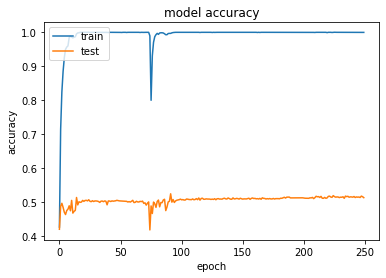

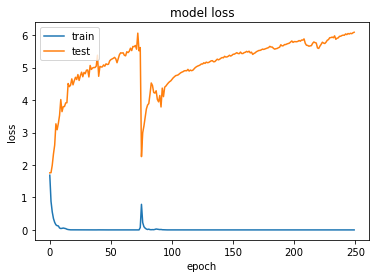

In [35]:
# summarize history for accuracy
plt.plot(model_mfc.history['accuracy'])
plt.plot(model_mfc.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_mfc.history['loss'])
plt.plot(model_mfc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
#Avg Test accuracy and Standart Devision 

In [37]:
train_hist = pd.DataFrame(model_mfc.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,1.685938,0.427651,1.758284,0.421214
1,0.880357,0.714381,1.763597,0.488306
2,0.556330,0.824183,1.992485,0.497519
3,0.351391,0.884196,2.339618,0.485708
4,0.232256,0.925094,2.612702,0.471297
...,...,...,...,...
245,0.000863,0.999555,6.035327,0.515946
246,0.000839,0.999555,6.059088,0.514529
247,0.000689,0.999333,6.045409,0.518545
248,0.000719,0.999555,6.073532,0.516891


In [38]:
print(train_hist["val_accuracy"].describe())

count    250.000000
mean       0.506494
std        0.012295
min        0.419324
25%        0.503721
50%        0.509922
75%        0.513052
max        0.525396
Name: val_accuracy, dtype: float64


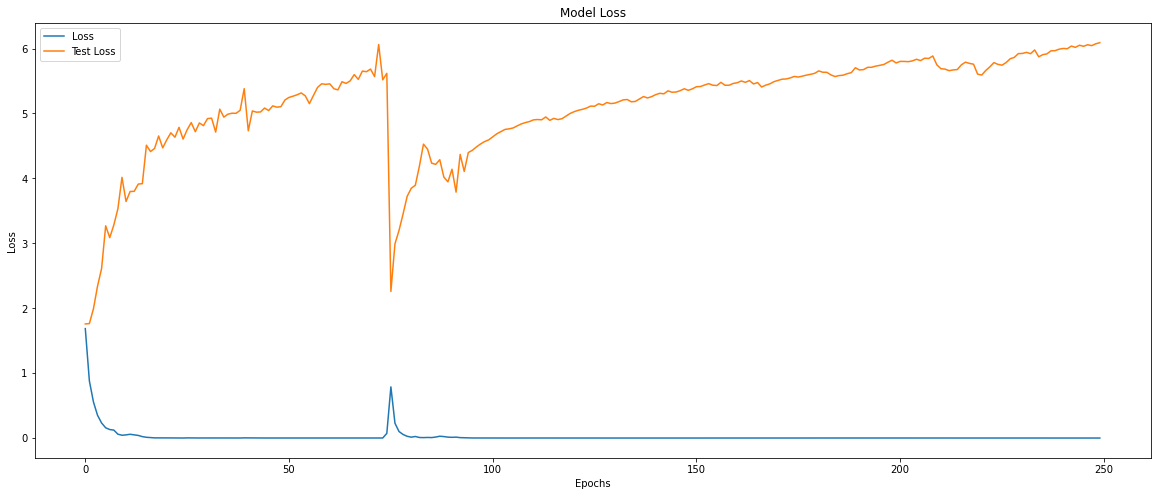

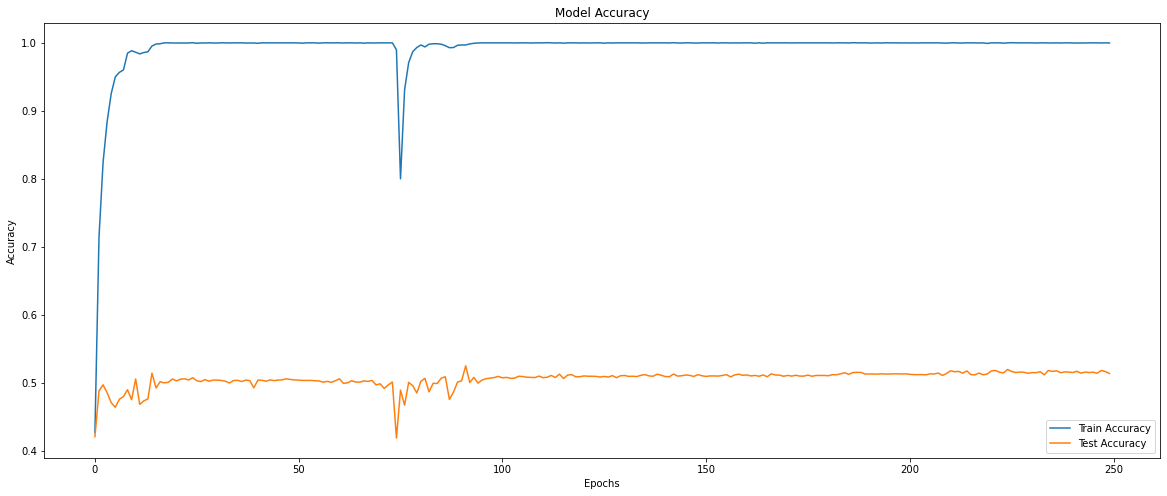

In [39]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['Loss','Test Loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [40]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[143   5  56  38   6  45   5  54  31 117]
 [  2 164   5   4   3   3   0   5   1  34]
 [ 12   1 278  60   7  14  17  17  42  52]
 [ 22   2  41 340  11  11  10   8  27  28]
 [  2   8  55  55 192   7   6  68  22  85]
 [ 29   2  75  71   9 224   0   5  25  43]
 [  2   3  24  31   1   2 110   0  10   1]
 [ 13  20  12   6 168  19   5 142   2  65]
 [  7   3  16  58   5  15   2   4 269  14]
 [ 18   7  39  38  29  12   3  19  21 314]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.57      0.29      0.38       500
           1       0.76      0.74      0.75       221
           2       0.46      0.56      0.50       500
           3       0.49      0.68      0.57       500
           4       0.45      0.38      0.41       500
           5       0.64      0.46      0.54       483
           6       0.70      0.60      0.64       184
           7       0.44      0.31      0.37       452
           8       0.60      0.